In [1]:
import os, sys, pathlib, importlib
sys.path.append('../')

# Load the package and modules for training and plotting
import nsbi_common_utils
from nsbi_common_utils import plotting, training, datasets, configuration
from nsbi_common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN


import tensorflow as tf
tf.config.optimizer.set_jit(False)
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle
import yaml
import random

from utils import preselection_using_score, calculate_preselection_observable

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

/home/jsandesara_umass_edu/NSBI-workflow-tutorial/src/nsbi_common_utils/plotting.py:11: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-10-24 15:53:44.019952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-24 15:53:44.041073: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-24 15:53:44.047336: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-24 15:53:44.063014: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CP

In [38]:
## TODOs
## define mutable vs immutable information

config = nsbi_common_utils.configuration.ConfigManager(file_path_string = './config.yml')

In [40]:
importlib.reload(sys.modules['nsbi_common_utils.datasets'])
from nsbi_common_utils import datasets

Datasets = nsbi_common_utils.datasets.datasets(config_path = './config.yml',
                                                branches_to_load = features)

In [41]:
# Get the dictionary of labels to processes
train_label_sample_dict = {"htautau"        : 0,
                            "ttbar"         : 1,
                            "ztautau"       : 2}

In [42]:
dataset_incl_dict = Datasets.load_datasets_from_config(load_systematics = True)

dataset_incl_nominal = dataset_incl_dict["Nominal"].copy()

In [44]:
dataset_incl_nominal_training = Datasets.merge_dataframe_dict_for_training(dataset_incl_nominal, 
                                                                            train_label_sample_dict,
                                                                            samples_to_merge = dataset_incl_nominal.keys())

Training the Preselection NN
===

**Choice of reference sample**

The density ratios need to be trained on phase space regions with support for the reference hypothesis $p_{ref}(x) > 0$.

To ensure this, we make a selection that selects events in the phase space regions with $p_{ref}(x) > 0$, or $p_c(x) \gg p_{ref}(x)$, and only perform the NSBI fit in this selected analysis region. **A natural choice for the reference hypothesis is then the signal-rich hypotheses**. This is referred to in the ATLAS publications as the Search-Oriented Mixture Models approach: 

$$p_{ref}(x) = \frac{1}{\sum_S \nu_S} \sum_S \frac{d\sigma_S}{dx} = \frac{1}{\nu_{H \to \tau\tau}} \frac{d\sigma_{H \to \tau\tau}}{dx}$$

where the sum runs over all signal hypothesis in the model and the second equality is due to the sole signal hypothesis in our toy model, $pp \to {t\bar{t}}$. 

**Selecting out regions with $p_{ref}\sim 0$**

A multi-class classification NN, with softmax output, is trained to output a score:

$$ \text{NN}_\text{presel} = \log \left[\frac{\sum_S P_S (x)}{\sum_B P_B(x)} \right]$$

where $P_c$ are the probability scores outputted from the softmax layer of the trained NN.



In [45]:
features, features_scaling = config.get_training_features()

print(features)

['DER_mass_transverse_met_lep', 'log_DER_mass_vis', 'log_DER_pt_h', 'DER_deltar_had_lep', 'log_DER_pt_tot', 'log_DER_sum_pt', 'DER_pt_ratio_lep_had', 'DER_met_phi_centrality']


In [46]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluatePreselNN

PATH_PRESEL_MODEL = './saved_datasets/preselection_model/'

# If the preselection NN has already been trained and saved, load from the saved model
USE_SAVED_MODEL_PRESEL = False


preselectionTraining = TrainEvaluatePreselNN(dataset_incl_nominal_training, 
                                            features, 
                                            features_scaling)

if not USE_SAVED_MODEL_PRESEL:
    preselectionTraining.train(test_size=0.2, 
                                random_state=42, 
                                path_to_save=PATH_PRESEL_MODEL,
                                batch_size=4096,
                                epochs=50, 
                                learning_rate=0.1)

else:
    preselectionTraining.assign_trained_model(PATH_PRESEL_MODEL)


2025-10-24 16:04:28.338350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


Epoch 1/50


2025-10-24 16:04:31.402970: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-24 16:04:31.517522: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


880/880 - 12s - 14ms/step - accuracy: 0.7785 - loss: 3.4931e-07 - val_accuracy: 0.7900 - val_loss: 3.3400e-07 - learning_rate: 0.1000
Epoch 2/50
880/880 - 7s - 8ms/step - accuracy: 0.7948 - loss: 3.2799e-07 - val_accuracy: 0.7988 - val_loss: 3.2221e-07 - learning_rate: 0.1000
Epoch 3/50
880/880 - 7s - 8ms/step - accuracy: 0.8013 - loss: 3.1896e-07 - val_accuracy: 0.8041 - val_loss: 3.1559e-07 - learning_rate: 0.1000
Epoch 4/50
880/880 - 7s - 8ms/step - accuracy: 0.8053 - loss: 3.1287e-07 - val_accuracy: 0.8068 - val_loss: 3.1019e-07 - learning_rate: 0.1000
Epoch 5/50
880/880 - 7s - 8ms/step - accuracy: 0.8075 - loss: 3.0907e-07 - val_accuracy: 0.8080 - val_loss: 3.0802e-07 - learning_rate: 0.1000
Epoch 6/50
880/880 - 7s - 8ms/step - accuracy: 0.8091 - loss: 3.0647e-07 - val_accuracy: 0.8102 - val_loss: 3.0484e-07 - learning_rate: 0.1000
Epoch 7/50
880/880 - 7s - 8ms/step - accuracy: 0.8105 - loss: 3.0432e-07 - val_accuracy: 0.8111 - val_loss: 3.0327e-07 - learning_rate: 0.1000
Epoch 8/

2025-10-24 16:10:35.015281: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-10-24 16:10:35.022029: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2025-10-24 16:10:35.127432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2025-10-24 16:10:35.139093: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-10-24 16:10:35.145714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capab

In [53]:
for region_name, dataset_sample_dict in dataset_incl_dict.items():

    for sample_name, dataset in dataset_sample_dict.items():

        # Get predictions (softmax outputs)
        pred_NN_incl = preselectionTraining.predict(dataset)
        presel_score = calculate_preselection_observable(pred_NN_incl, 
                                                        train_label_sample_dict, 
                                                        signal_processes       = ['htautau'], 
                                                        background_processes   = ['ttbar', 'ztautau'], 
                                                        pre_factor_dict        = {'htautau': 1.0, 'ttbar': 1.0, 'ztautau': 1.0})

        dataset_incl_dict[region_name][sample_name]['presel_score'] = presel_score


In [54]:
Datasets.add_appended_branches(['presel_score'])
Datasets.save_datasets(dataset_incl_dict, save_systematics = True)

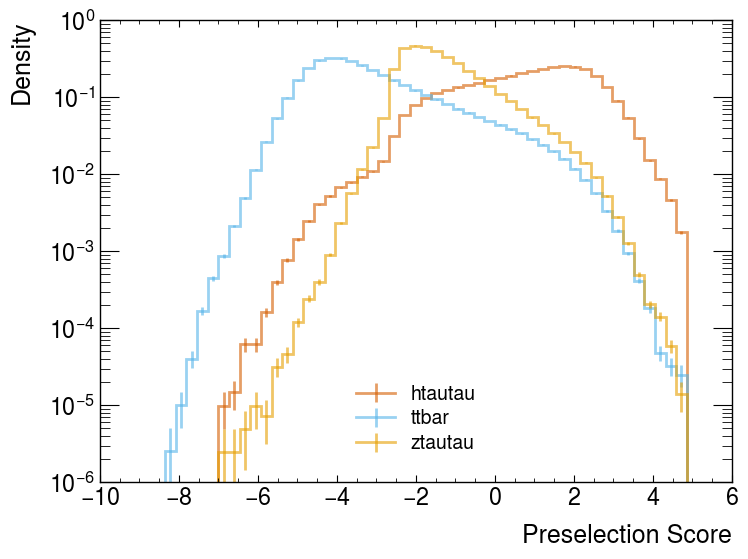

In [55]:
min_pred = np.amin(presel_score)
max_pred = np.amax(presel_score)

bins = np.linspace(min_pred, max_pred, num=50)

hist_NN_output          = {}
hist_NN_output_errs     = {}

presel_score_arr        = {}

for sample_name, sample_dataset in dataset_incl_dict["Nominal"].items():

    presel_score_arr    = sample_dataset['presel_score']
    weights             = sample_dataset['weights']

    hist_NN_output[sample_name], _          = np.histogram(presel_score_arr, weights = weights,     bins=bins)
    
    hist_NN_output_errs[sample_name], _     = np.histogram(presel_score_arr, weights = weights**2,  bins=bins)

    hep.histplot(hist_NN_output[sample_name], bins=bins, 
             alpha=0.6, label=sample_name, 
             density=True, linewidth=2.0, yerr = np.sqrt(hist_NN_output_errs[sample_name]))

plt.xlabel("Preselection Score", size=18)
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

Making the cut
===

Make a selection cut for regions with $p_{ref} \gg 0$ for performing the NSBI analysis. The remaining events - which by definition are background-dominated - can be used as a **Control Region** for data-driven background estimation, pre-unblinding validations, etc. 

Moreover, the preselections act as a tuning know for the tradeoff in selecting as many signal events as possible to go into the **Signal Region** (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics). **The preselections can also weed out phase space regions with low background statistics to avoid poorly modelled regions.** 

Heres a first cut that you can optimize as much as you like to get the desired final results. 

In [56]:
# Play around with these selections - decrease if estimators are unbiased but need more sensitivity and increase if the model is biased to reduce complexity
preselection_cuts = {'upper': 4.5, 'lower': -1.}

## Convert to an object that takes inputs - better for dynamic changing

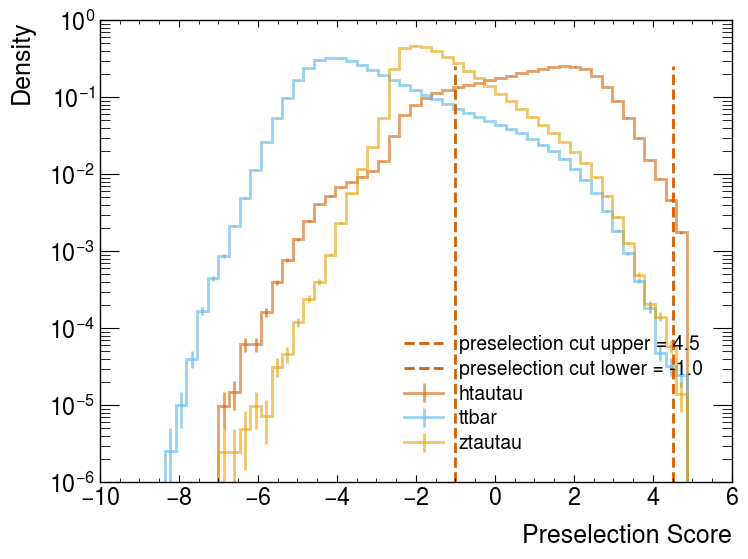

In [57]:

for sample_name, sample_dataset in dataset_incl_dict["Nominal"].items():

    hep.histplot(hist_NN_output[sample_name], bins=bins, 
             alpha=0.6, label=sample_name, 
             density=True, linewidth=2.0, yerr = np.sqrt(hist_NN_output_errs[sample_name]))

for key in preselection_cuts:
    if preselection_cuts[key] != -999:
        plt.axvline(preselection_cuts[key], ymax=0.9, linestyle='--', label=f'preselection cut {key} = {preselection_cuts[key]}')


plt.xlabel("Preselection Score", size=18)
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

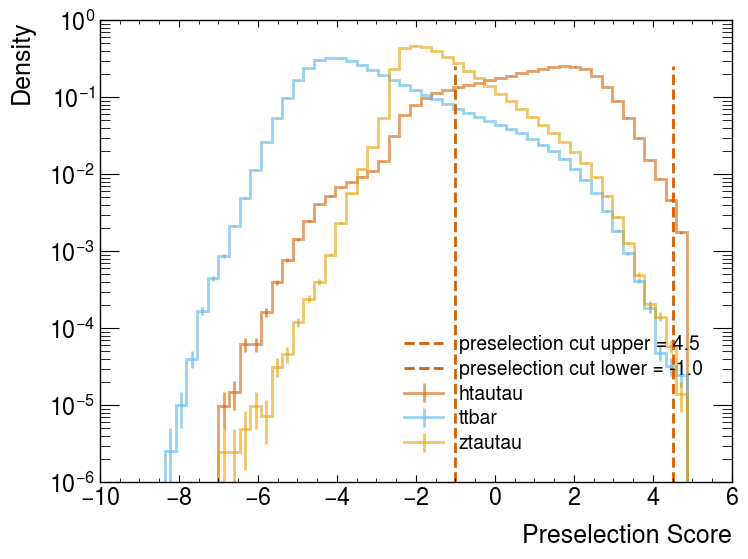

In [58]:
for key in train_label_sample_dict:  
    hep.histplot(hist_NN_output[key], bins = bins, 
             alpha = 0.6, label = key, 
             density = True, linewidth = 2.0, 
                 yerr = np.sqrt(hist_NN_output_errs[key]))

plt.xlabel("Preselection Score", size=18)

for key in preselection_cuts:
    if preselection_cuts[key] != -999:
        plt.axvline(preselection_cuts[key], ymax=0.9, linestyle='--', label=f'preselection cut {key} = {preselection_cuts[key]}')

plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

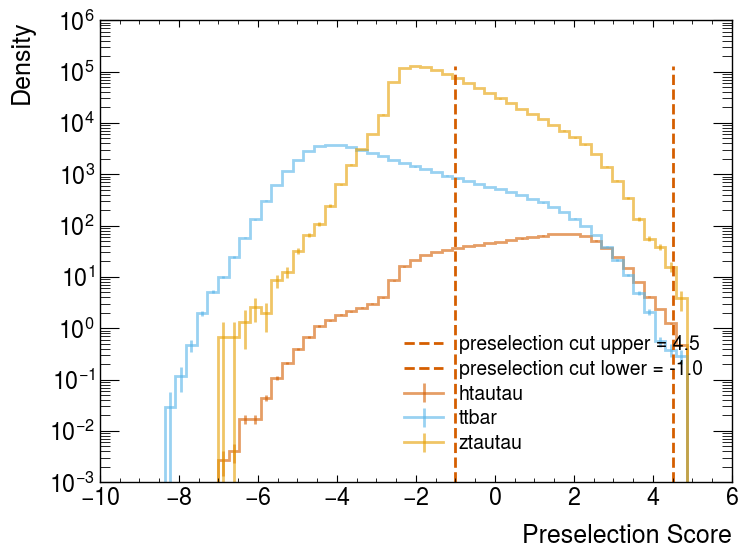

In [59]:
for key in train_label_sample_dict:  
    hep.histplot(hist_NN_output[key], bins = bins, 
             alpha = 0.6, label = key, 
             density = False, linewidth = 2.0, 
                 yerr = np.sqrt(hist_NN_output_errs[key]))

plt.xlabel("Preselection Score", size=18)

for key in preselection_cuts:
    if preselection_cuts[key] != -999:
        plt.axvline(preselection_cuts[key], ymax=0.9, linestyle='--', label=f'preselection cut {key} = {preselection_cuts[key]}')

plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

Signal and Control Regions
===

The high signal over background phase space towards the right of the preselection cut shown above will be categorized as the **Signal Region** where the NSBI analysis is performed.

The low signal phase space towards the left will be used as a **Control Region**, with typical uses such as background estimation, pre-unblinding data-MC checks, etc. In this phase space, we will use a binned summary observable like in any traditional analysis.